## Importazione e preprocessing

### Importazione pacchetti

In [1]:
#Stile di visualizzazione plot fatti con matplotlib
%matplotlib inline

#Base
import os
import pandas as pd
import numpy as np
import scipy as sp
import time
import sys

#Visualizzazione
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sn  #Per heatmap

#Preprocessing e altro
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, ParameterGrid
sys.path.insert(1, '../Data')
from preprocessing import preprocessing_diabetes
from preprocessing_v2 import preprocessing_diabetes_v2
from imblearn.over_sampling import SMOTE

#Modelli
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC as SupportVectorMachineClassifier
from sklearn.neural_network import MLPClassifier

#Metriche
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, make_scorer

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

### Importazione dati

In [3]:
trainingData = pd.read_csv('../Data/diabetes_train.csv')
testData = pd.read_csv('../Data/diabetes_test.csv')

In [4]:
df_train_scal, df_test_scal, y_train, y_test = preprocessing_diabetes(trainingData, testData)
df_train_noFeat, df_test_noFeat, _, _ = preprocessing_diabetes(trainingData, testData, option='Delete')
df_train_PCA, df_test_PCA, _, _ = preprocessing_diabetes(trainingData, testData, option='PCA')

df_train_scal_os, df_test_scal_os, y_train_os, y_test_os = preprocessing_diabetes_v2(trainingData, testData, oversample=True)
df_train_noFeat_os, df_test_noFeat_os, _, _ = preprocessing_diabetes_v2(trainingData, testData, option='Delete', oversample=True)
df_train_PCA_os, df_test_PCA_os, _, _ = preprocessing_diabetes_v2(trainingData, testData, option='PCA', oversample=True)

#No smoking
df_train_noSmok = df_train_scal[[col for col in df_train_scal.columns if 'smoking' not in col]]
df_test_noSmok = df_test_scal[[col for col in df_test_scal.columns if 'smoking' not in col]]

df_train_noSmok_os = df_train_scal_os[[col for col in df_train_scal_os.columns if 'smoking' not in col]]
df_test_noSmok_os = df_test_scal_os[[col for col in df_test_scal_os.columns if 'smoking' not in col]]

In [5]:
display(df_train_scal)

,age,bmi,HbA1c_level,blood_glucose_level,Insulin_Sensitivity_Est,BMI_Glucose_Interaction,Random_Lab_Marker,gender,hypertension,heart_disease,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0.894928,-0.176195,0.503722,0.095442,0.476212,-0.055814,-1.175480,1,0,0,False,False,False,True,False
1,0.668110,0.758421,1.541394,-0.072366,0.007480,0.266092,-1.007407,1,1,0,False,False,False,True,False
2,1.034925,0.365698,2.218108,1.701715,0.481892,1.438787,0.651317,1,0,0,False,False,True,False,False
3,0.579111,0.667063,2.104176,0.043478,0.716419,0.317432,-0.953973,1,0,0,False,False,False,True,False
4,1.146937,1.446470,0.321064,0.328064,-0.132528,0.907586,0.423327,1,0,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,-1.205383,0.064420,-0.402472,0.164156,0.179832,0.206146,0.311464,0,0,0,False,False,True,False,False
582,1.134089,-0.535417,-1.650545,0.127452,-2.138018,-0.213306,-0.655270,0,0,0,False,False,False,False,True
583,0.672161,0.122466,-0.008653,-0.142200,-1.439506,-0.080177,0.943590,1,0,1,True,False,False,False,False
584,-0.852201,-0.142217,0.134120,0.917149,0.000000,0.521425,1.180482,0,0,0,False,False,False,False,False


## Multi-Layer Perceptron

In [6]:
random_seed = 42

In [7]:
# Creazione di una sottomappa di viridis, in modo da avere il verde come massimo
viridis = matplotlib.colormaps['viridis'].resampled(280)
newcolors = viridis(np.linspace(0, 1, 280))[:210]
newcmp=matplotlib.colors.ListedColormap(newcolors)

In [8]:
def performances(model,data,y_true,title=None):
    start=time.time()
    y_pred=model.predict(data)
    stop=time.time()
    totalTime=stop-start
    acc = model.score(data, y_true)
    prec = precision_score(y_true, y_pred, average='binary')
    rec = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    df = pd.DataFrame({'Accuracy': [acc], 
                        'Precision': [prec ], 
                        'Recall': [rec ],
                        'F1': [f1 ]
                       },
                      index=[title])
    cmat=pd.DataFrame(confusion_matrix(y_true,y_pred,labels=model.classes_))
    return df,cmat,totalTime

In [ ]:
def heatMapConstr(heatMapMatrices, titles):
    fig,axs=plt.subplots(1,4,figsize=(15,3))
    for i in range(4):
        normMatrix=heatMapMatrices[i].div(heatMapMatrices[i].sum(axis=1), axis=0)
        ax=axs[i]
        im=ax.imshow(normMatrix,vmin=0,vmax=1,cmap=newcmp)
        ax.set_yticks(range(len(heatMapMatrices[i].index)))
        ax.set_yticklabels(heatMapMatrices[i].index)
        ax.set_xticks(range(len(heatMapMatrices[i].columns)))
        ax.set_xticklabels(heatMapMatrices[i].columns)
        ax.title.set_text(titles[i])
        ax.set_xlabel("predicted")
        ax.set_ylabel("true")
        for a in range(len(heatMapMatrices[i].index)):
            for j in range(len(heatMapMatrices[i].columns)):
                text = ax.text(j, a, heatMapMatrices[i].iloc[a, j], ha="center", va="center", color='w')
    #plt.savefig('Confusion_matrices_mlp_ig',dpi=300)
    fig.tight_layout()
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    #plt.savefig('gs_SVM_'+scoreInterest,dpi=300)
    plt.show()

In [10]:
def heatMapGridSearch(modelResults, gridDict, scoreInterest):  # mean_test_score, mean_train_score, mean_fit_time
    vmin=modelResults[scoreInterest].min()
    vmax=1
    if scoreInterest=='time':
        vmax=modelResults[scoreInterest].max()

    fig,axs=plt.subplots(1,len(gridDict['batch_size']),figsize=(15,4))
    for i,bs in enumerate(gridDict['batch_size']):
        square=pd.DataFrame()
        for act in gridDict['activation']:
            col=pd.DataFrame()
            for alp in gridDict['alpha']:
                df = modelResults[modelResults['param_batch_size']==bs][modelResults['param_activation']==act][modelResults['param_alpha']==alp][modelResults['param_learning_rate']=='constant']
                df=df.pivot(index='layers', columns='layerSize', values=scoreInterest)
                col=pd.concat([col,df])
            square=pd.concat([square,col], axis=1)

        ax=axs[i]
        im=ax.imshow(square.astype(float),vmin=vmin,vmax=vmax,cmap=newcmp)
        ax.set_yticks(range(len(square.index)))
        ax.set_yticklabels(square.index)
        ax.set_xticks(range(len(square.columns)))
        ax.set_xticklabels(square.columns)
        #ax.title.set_text(bs)
        ax.set_xlabel("layerSize")
        ax.set_ylabel("layers")
        for a in range(len(square.index)):
            for j in range(len(square.columns)):
                c="w"
                if square.iloc[a, j]==modelResults[scoreInterest].max():
                    c="red"
                elif square.iloc[a, j]==square.values.max():
                    c="gold"
                text = ax.text(j, a, "{0:.2f}".format(square.iloc[a, j]),
                            ha="center", va="center", color=c)
        #Linee verticali e orizzontali di separazione
        ax.axhline(y=3.5,c="black",linewidth=0.75,zorder=0)
        ax.axvline(x=3.5,c="black",linewidth=0.75,zorder=0)
        #Testi aggiuntivi degli assi mancanti e titolo
        ax.text(3.5, -1.5, 'batchSize = '+str(bs), ha="center", va="center", fontsize=12)
        ax.text(8.25, 3.5, 'alpha', ha="center", va="center", rotation='vertical')
        ax.text(1.5, -0.75, gridDict['activation'][0], ha="center", va="center")
        ax.text(5.5, -0.75, gridDict['activation'][1], ha="center", va="center")
        ax.text(7.75, 1.5, gridDict['alpha'][0], ha="left", va="center")
        ax.text(7.75, 5.5, gridDict['alpha'][1], ha="left", va="center")

    cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    #plt.savefig('MLP_'+scoreInterest,dpi=300)
    plt.show()
    print('MIGLIORI IPERPARAMETRI')
    max_elem_row=modelResults[scoreInterest].astype(float).idxmax()
    bestModel = modelResults.iloc[max_elem_row]
    bestModelShort = bestModel[[idx for idx in bestModel.index if 'param' in idx and 'params' not in idx]+['mean_train_score','mean_test_score','mean_fit_time']]
    display(pd.DataFrame(bestModelShort).transpose())
    return bestModel

### Grid Search e train

In [11]:
layerSize=[50,100,200,250]
layers=[1,2,3,5]
hiddenLayerSizes=[]
for i in layerSize:
    for j in layers:
        hiddenLayerSizes.append([i]*j)
print(hiddenLayerSizes)
GRID = {
    'hidden_layer_sizes': hiddenLayerSizes,
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],  #Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
    'max_iter': [1000],
    'learning_rate': ['constant'], #, 'adaptive'],
    #'n_iter_no_change': [75, 150],
    'batch_size': [10, 50, 200]
}

[[50], [50, 50], [50, 50, 50], [50, 50, 50, 50, 50], [100], [100, 100], [100, 100, 100], [100, 100, 100, 100, 100], [200], [200, 200], [200, 200, 200], [200, 200, 200, 200, 200], [250], [250, 250], [250, 250, 250], [250, 250, 250, 250, 250]]


#### Classico

In [12]:
#Dichiarazione della svm
mlp1 = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_gs = GridSearchCV(estimator=mlp1,
                      param_grid=GRID,
                      scoring='f1',
                      cv=10,
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_gs.fit(df_train_scal, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1 = pd.DataFrame(mlp1_gs.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


In [13]:
display(results1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.375589,0.123926,0.006632,0.001586,tanh,0.0001,10,[50],constant,1000,...,0.897338,0.904215,0.853846,0.889734,0.865900,0.898113,0.888060,0.906367,0.888813,0.015902
1,0.517551,0.183496,0.006564,0.001124,tanh,0.0001,10,"[50, 50]",constant,1000,...,0.870229,0.878788,0.897638,0.916031,0.892430,0.906367,0.888889,0.899628,0.887310,0.017856
2,0.414993,0.152712,0.005750,0.001100,tanh,0.0001,10,"[50, 50, 50]",constant,1000,...,0.867925,0.868914,0.868217,0.875969,0.870849,0.868914,0.845588,0.885609,0.867485,0.009950
3,0.682863,0.397517,0.005711,0.001459,tanh,0.0001,10,"[50, 50, 50, 50, 50]",constant,1000,...,0.897059,0.900000,0.887273,0.918919,0.917293,0.903704,0.912409,0.913208,0.903087,0.011207
4,0.235230,0.076480,0.006303,0.002579,tanh,0.0001,10,[100],constant,1000,...,0.888031,0.853755,0.845878,0.864469,0.869231,0.857143,0.860215,0.858156,0.862101,0.010991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2.123808,0.814864,0.012402,0.002972,relu,0.0500,200,"[200, 200, 200, 200, 200]",constant,1000,...,0.888889,0.928058,0.932384,0.931818,0.976923,0.943396,0.943396,0.981413,0.931339,0.030924
188,0.227281,0.067388,0.010965,0.004956,relu,0.0500,200,[250],constant,1000,...,0.834008,0.848000,0.835341,0.826446,0.824490,0.838710,0.806723,0.821577,0.828427,0.010659
189,1.000819,0.424280,0.012417,0.005433,relu,0.0500,200,"[250, 250]",constant,1000,...,0.729858,0.906977,0.926641,0.910506,0.903475,0.653266,0.601036,0.701923,0.812685,0.120464
190,1.631202,0.392982,0.010683,0.002157,relu,0.0500,200,"[250, 250, 250]",constant,1000,...,0.871212,0.854839,0.935849,0.915385,0.929368,0.916667,0.916667,0.932836,0.907492,0.030210


#### No correlation

In [14]:
#Dichiarazione della svm
mlp1_noFeat = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_noFeat_gs = GridSearchCV(estimator=mlp1_noFeat,
                      param_grid=GRID,
                      scoring='f1',
                      cv=10,
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_noFeat_gs.fit(df_train_noFeat, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noFeat = pd.DataFrame(mlp1_noFeat_gs.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


#### No smoking

In [15]:
#Dichiarazione della svm
mlp1_noSmok = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_noSmok_gs = GridSearchCV(estimator=mlp1_noSmok,
                      param_grid=GRID,
                      scoring='f1',
                      cv=10,
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_noSmok_gs.fit(df_train_noSmok, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noSmok = pd.DataFrame(mlp1_noSmok_gs.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


#### PCA

In [16]:
#Dichiarazione della svm
mlp1_PCA = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_PCA_gs = GridSearchCV(estimator=mlp1_PCA,
                      param_grid=GRID,
                      scoring='f1',
                      cv=10,
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_PCA_gs.fit(df_train_PCA, y_train)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_PCA = pd.DataFrame(mlp1_PCA_gs.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


#### Classico - Oversampling

In [17]:
#Dichiarazione della svm
mlp1_os = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_gs_os = GridSearchCV(estimator=mlp1_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=10,
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_gs_os.fit(df_train_scal_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_os = pd.DataFrame(mlp1_gs_os.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


In [18]:
display(results1_os)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.857639,0.495469,0.005637,0.002586,tanh,0.0001,10,[50],constant,1000,...,0.931507,0.938519,0.929648,0.938979,0.940150,0.936330,0.909988,0.932500,0.931164,0.008543
1,1.155388,0.568385,0.014043,0.018821,tanh,0.0001,10,"[50, 50]",constant,1000,...,0.962500,0.920988,0.957286,0.909765,0.946701,0.906863,0.927500,0.907749,0.928921,0.019712
2,1.782498,1.287842,0.012118,0.019811,tanh,0.0001,10,"[50, 50, 50]",constant,1000,...,0.933162,0.939850,0.968711,0.984810,0.931298,0.994949,0.971214,0.962594,0.954729,0.023401
3,3.370772,1.280991,0.007670,0.004210,tanh,0.0001,10,"[50, 50, 50, 50, 50]",constant,1000,...,0.987469,0.993695,0.977612,0.987500,0.982587,0.988708,0.986267,0.986267,0.985639,0.004327
4,0.462449,0.314821,0.012060,0.019184,tanh,0.0001,10,[100],constant,1000,...,0.925786,0.922693,0.916456,0.913642,0.917500,0.914787,0.930000,0.930693,0.920157,0.006337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2.886752,1.398769,0.014288,0.006610,relu,0.0500,200,"[200, 200, 200, 200, 200]",constant,1000,...,0.970996,0.984887,0.967500,0.970996,0.949749,0.986233,0.982278,0.987500,0.974378,0.010875
188,0.314476,0.204203,0.004252,0.000082,relu,0.0500,200,[250],constant,1000,...,0.924623,0.916877,0.904585,0.911839,0.914573,0.911616,0.919192,0.907478,0.918815,0.011342
189,2.222459,0.841175,0.012415,0.004517,relu,0.0500,200,"[250, 250]",constant,1000,...,0.983607,0.982368,0.982412,0.986198,0.986198,0.983689,0.972222,0.981179,0.982266,0.003864
190,2.126699,0.404036,0.011074,0.003132,relu,0.0500,200,"[250, 250, 250]",constant,1000,...,0.983565,0.977273,0.978670,0.981084,0.964912,0.972292,0.977273,0.971214,0.976106,0.005097


#### No correlation - Oversampling

In [19]:
#Dichiarazione della svm
mlp1_noFeat_os = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_noFeat_gs_os = GridSearchCV(estimator=mlp1_noFeat_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=10,
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_noFeat_gs_os.fit(df_train_noFeat_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noFeat_os = pd.DataFrame(mlp1_noFeat_gs_os.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


#### No smoking - Oversampling

In [20]:
#Dichiarazione della svm
mlp1_noSmok_os = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_noSmok_gs_os = GridSearchCV(estimator=mlp1_noSmok_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=10,
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_noSmok_gs_os.fit(df_train_noSmok_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_noSmok_os = pd.DataFrame(mlp1_noSmok_gs_os.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


#### PCA - Oversampling

In [21]:
#Dichiarazione della svm
mlp1_PCA_os = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp1_PCA_gs_os = GridSearchCV(estimator=mlp1_PCA_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=10,
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp1_PCA_gs_os.fit(df_train_PCA_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results1_PCA_os = pd.DataFrame(mlp1_PCA_gs_os.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


### Visualizzazione

In [22]:
#Classico
results1['layers'] = results1.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1['layerSize'] = results1.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#No correlated feature
results1_noFeat['layers'] = results1_noFeat.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_noFeat['layerSize'] = results1_noFeat.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#No smoking
results1_noSmok['layers'] = results1_noSmok.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_noSmok['layerSize'] = results1_noSmok.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#PCA
results1_PCA['layers'] = results1_PCA.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_PCA['layerSize'] = results1_PCA.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#Classico - Oversampling
results1_os['layers'] = results1_os.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_os['layerSize'] = results1_os.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#No correlated feature - Oversampling
results1_noFeat_os['layers'] = results1_noFeat_os.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_noFeat_os['layerSize'] = results1_noFeat_os.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#No smoking - Oversampling
results1_noSmok_os['layers'] = results1_noSmok_os.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_noSmok_os['layerSize'] = results1_noSmok_os.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)
#PCA - Oversampling
results1_PCA_os['layers'] = results1_PCA_os.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results1_PCA_os['layerSize'] = results1_PCA_os.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)

In [23]:
results1.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_activation', 'param_alpha', 'param_batch_size',
       'param_hidden_layer_sizes', 'param_learning_rate', 'param_max_iter',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'split5_train_score', 'split6_train_score', 'split7_train_score',
       'split8_train_score', 'split9_train_score', 'mean_train_score',
       'std_train_score', 'layers', 'layerSize'],
      dtype='object')

CLASSICO


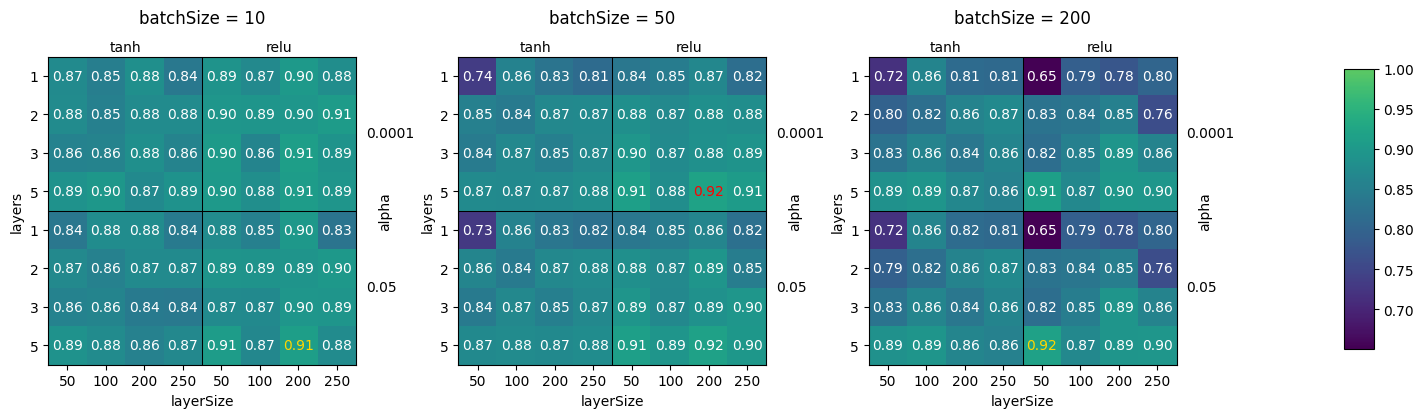

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
123,relu,0.0001,50,"[200, 200, 200, 200, 200]",constant,1000,0.957858,0.919178,3.781312


NO CORRELATED FEATURE


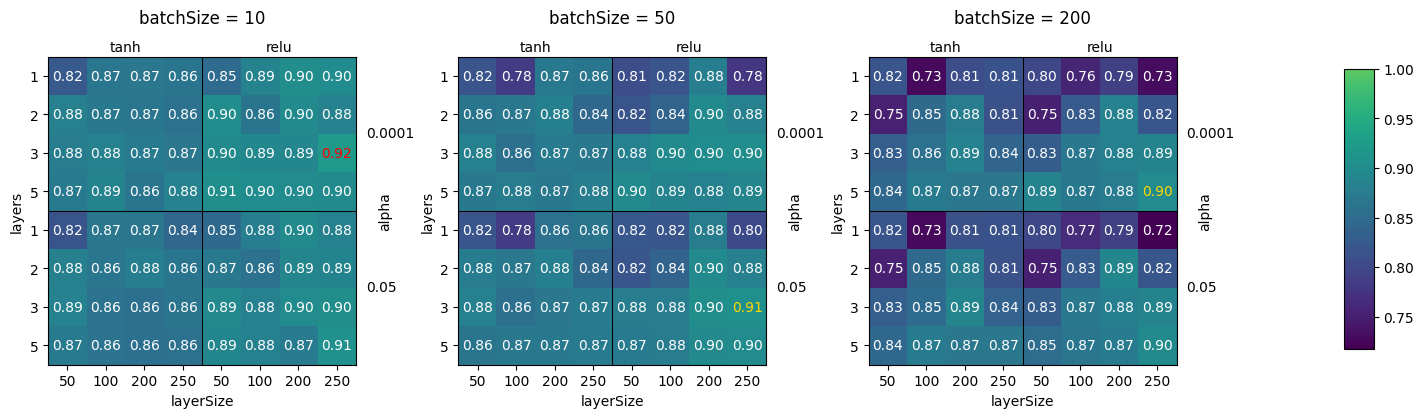

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
110,relu,0.0001,10,"[250, 250, 250]",constant,1000,0.98335,0.919458,14.496348


NO SMOKING


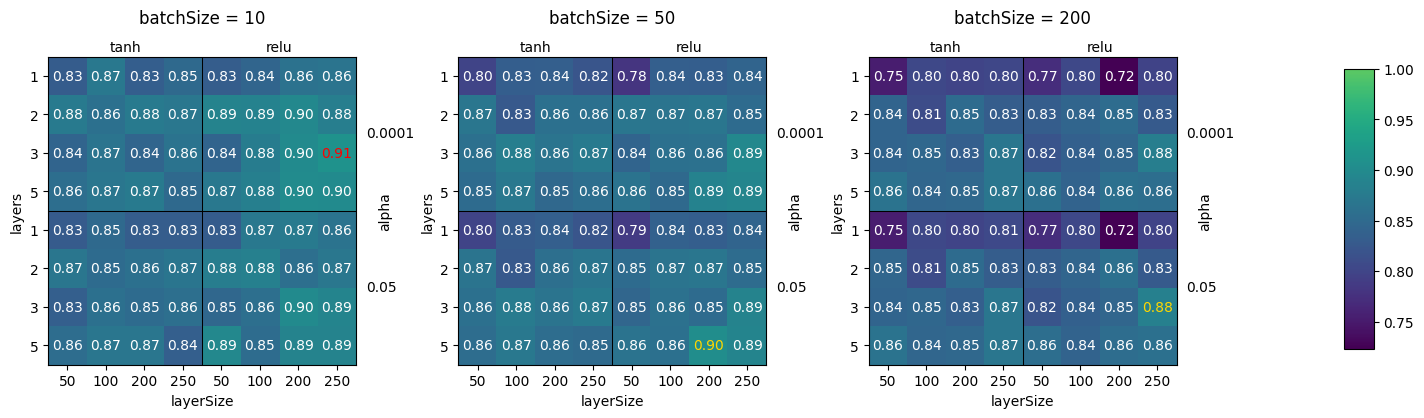

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
110,relu,0.0001,10,"[250, 250, 250]",constant,1000,0.971753,0.910691,11.692338


CON PCA


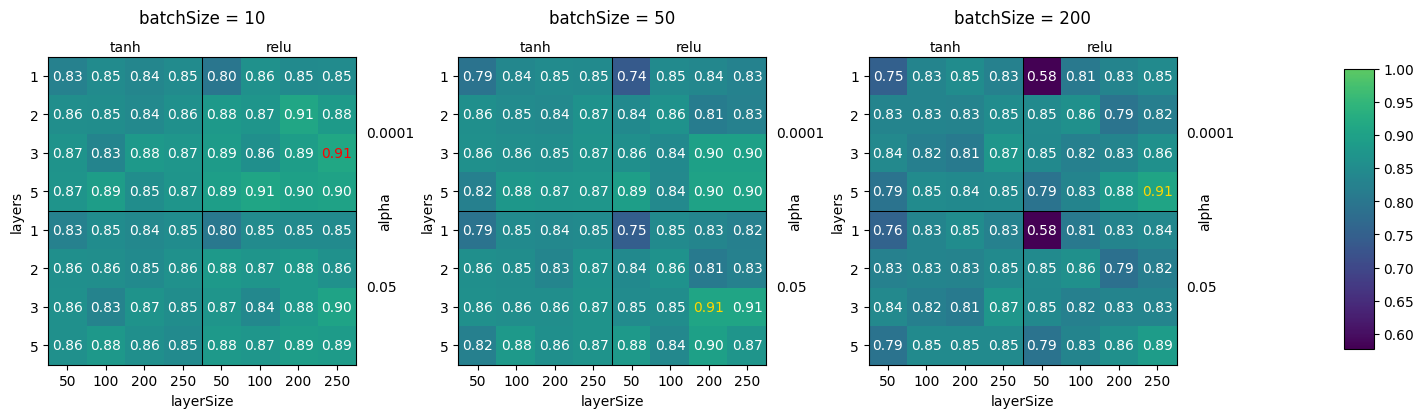

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
110,relu,0.0001,10,"[250, 250, 250]",constant,1000,0.981552,0.912584,8.965775


CLASSICO - OVERSAMPLING


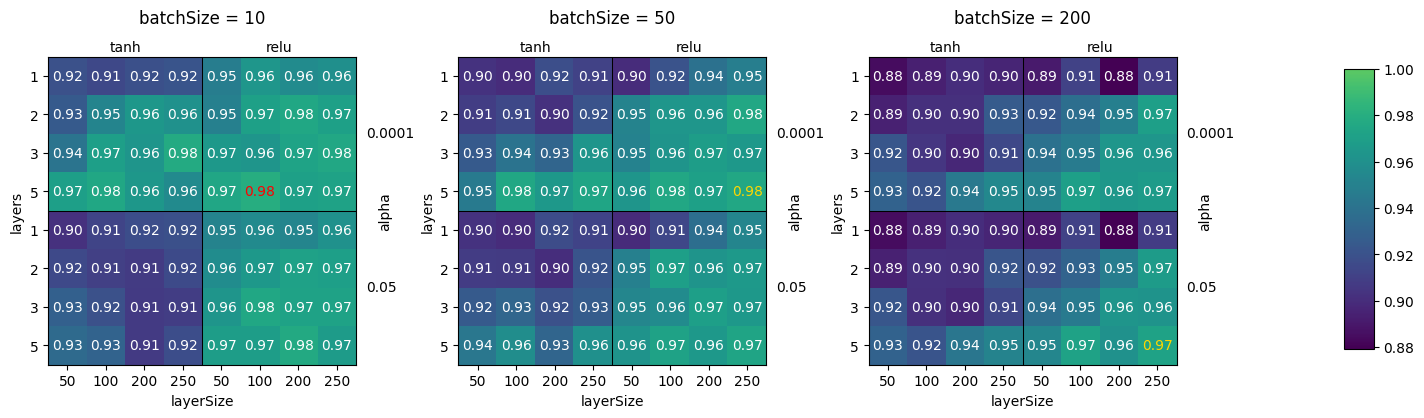

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
103,relu,0.0001,10,"[100, 100, 100, 100, 100]",constant,1000,0.996706,0.979719,5.29993


NO CORRELATED FEATURE - OVERSAMPLING


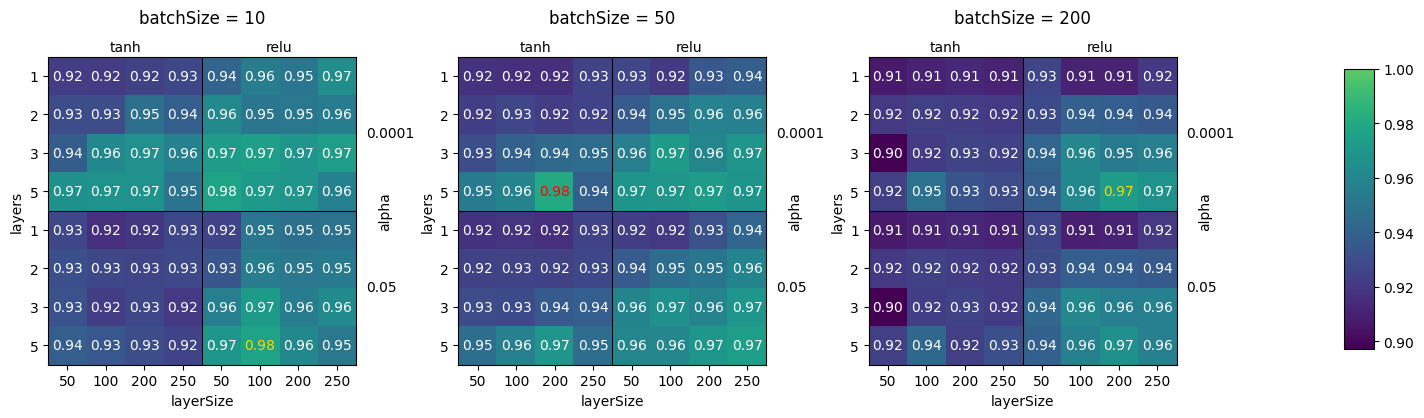

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
27,tanh,0.0001,50,"[200, 200, 200, 200, 200]",constant,1000,0.991684,0.981018,10.645394


NO SMOKING - OVERSAMPLING


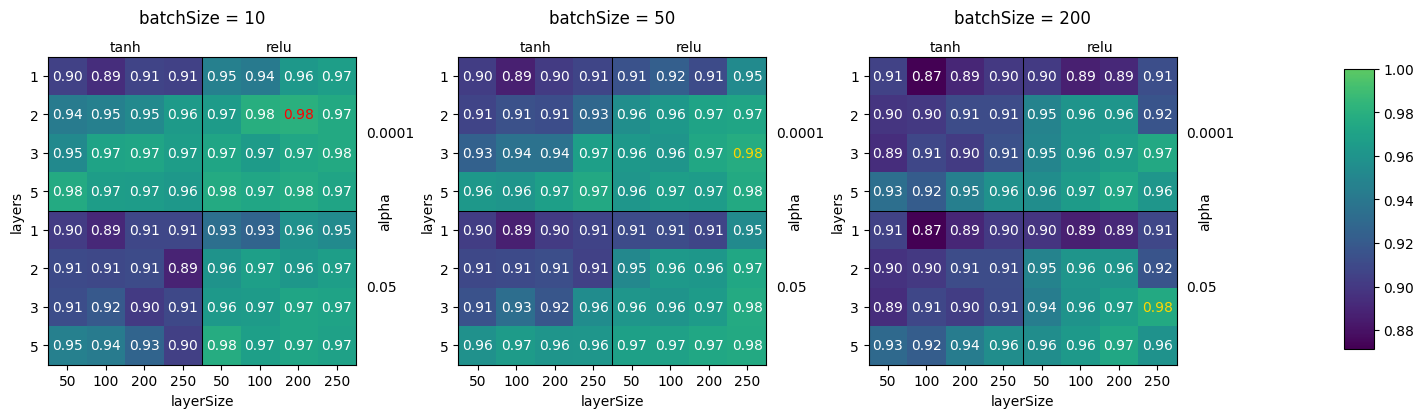

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
105,relu,0.0001,10,"[200, 200]",constant,1000,0.993082,0.979818,5.103703


CON PCA - OVERSAMPLING


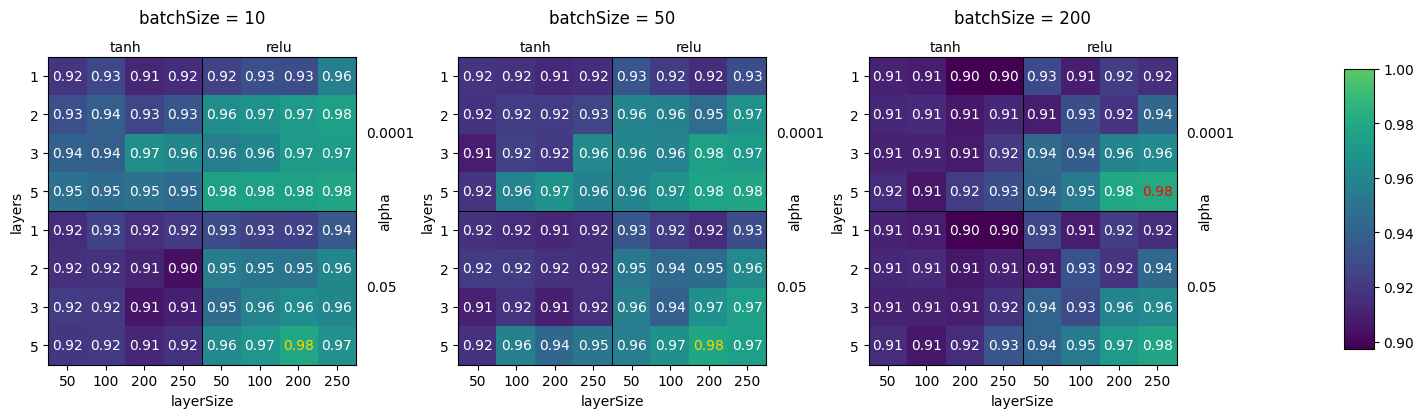

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
143,relu,0.0001,200,"[250, 250, 250, 250, 250]",constant,1000,0.997727,0.981017,6.147562


In [24]:
scoreInterest='mean_test_score'
print('CLASSICO')
bestModel = heatMapGridSearch(results1, GRID, scoreInterest)
print('NO CORRELATED FEATURE')
bestModel_noFeat = heatMapGridSearch(results1_noFeat, GRID, scoreInterest)
print('NO SMOKING')
bestModel_noSmok = heatMapGridSearch(results1_noSmok, GRID, scoreInterest)
print('CON PCA')
bestModel_PCA = heatMapGridSearch(results1_PCA, GRID, scoreInterest)
print('CLASSICO - OVERSAMPLING')
bestModel_os = heatMapGridSearch(results1_os, GRID, scoreInterest)
print('NO CORRELATED FEATURE - OVERSAMPLING')
bestModel_noFeat_os = heatMapGridSearch(results1_noFeat_os, GRID, scoreInterest)
print('NO SMOKING - OVERSAMPLING')
bestModel_noSmok_os = heatMapGridSearch(results1_noSmok_os, GRID, scoreInterest)
print('CON PCA - OVERSAMPLING')
bestModel_PCA_os = heatMapGridSearch(results1_PCA_os, GRID, scoreInterest)

### Raffinamento modello migliore

In [ ]:
layerSize=[75, 100,125,150]
layers=[4,5,8,10]
hiddenLayerSizes=[]
for i in layerSize:
    for j in layers:
        hiddenLayerSizes.append([i]*j)
print(hiddenLayerSizes)
GRID = {
    'hidden_layer_sizes': hiddenLayerSizes,
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.001],  #Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
    'max_iter': [1000],
    'learning_rate': ['constant'], #, 'adaptive'],
    #'n_iter_no_change': [75, 150],
    'batch_size': [30, 50, 100]
}

[[75, 75, 75, 75], [75, 75, 75, 75, 75], [75, 75, 75, 75, 75, 75, 75, 75], [75, 75, 75, 75, 75, 75, 75, 75, 75, 75], [100, 100, 100, 100], [100, 100, 100, 100, 100], [100, 100, 100, 100, 100, 100, 100, 100], [100, 100, 100, 100, 100, 100, 100, 100, 100, 100], [125, 125, 125, 125], [125, 125, 125, 125, 125], [125, 125, 125, 125, 125, 125, 125, 125], [125, 125, 125, 125, 125, 125, 125, 125, 125, 125], [150, 150, 150, 150], [150, 150, 150, 150, 150], [150, 150, 150, 150, 150, 150, 150, 150], [150, 150, 150, 150, 150, 150, 150, 150, 150, 150]]


In [26]:
#Dichiarazione della svm
mlp2_os = MLPClassifier(early_stopping=True, random_state=random_seed)

#Dichiarazione delle GridSearch
mlp2_gs_os = GridSearchCV(estimator=mlp2_os,
                      param_grid=GRID,
                      scoring='f1',
                      cv=10,
                      return_train_score=True,
                      verbose=1,
                      n_jobs=-1)
    
#"Addestramento" delle GridSearch
mlp2_gs_os.fit(df_train_scal_os, y_train_os)

# Mostriamo i risultati della Gridsearch con una tabella:
results2_os = pd.DataFrame(mlp2_gs_os.cv_results_)

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


NO CORRELATED FEATURE


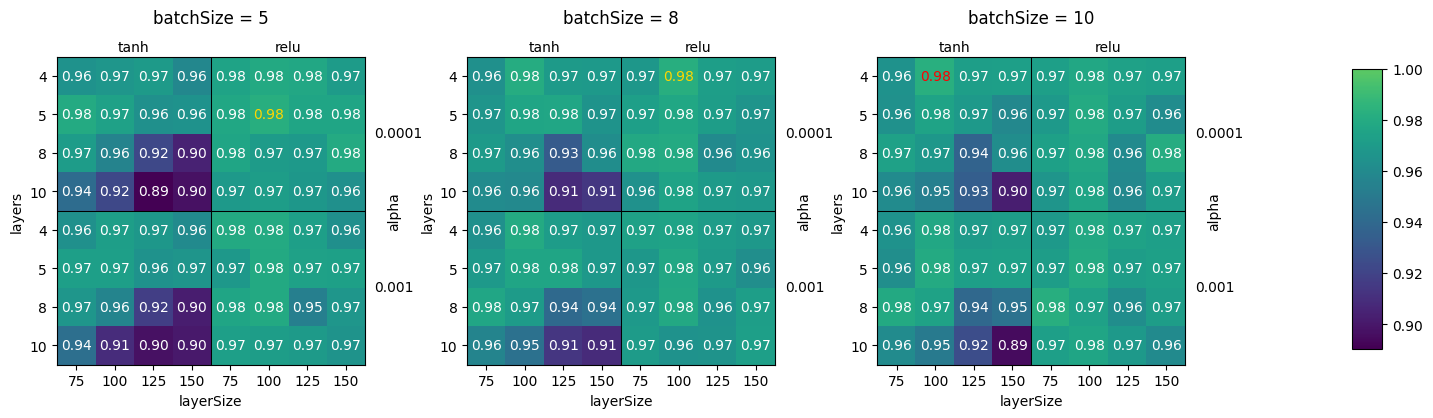

MIGLIORI IPERPARAMETRI


,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_learning_rate,param_max_iter,mean_train_score,mean_test_score,mean_fit_time
36,tanh,0.0001,10,"[100, 100, 100, 100]",constant,1000,0.988113,0.982318,4.769387


In [30]:
results2_os['layers'] = results2_os.apply(lambda x: len(x['param_hidden_layer_sizes']), axis=1)
results2_os['layerSize'] = results2_os.apply(lambda x: x['param_hidden_layer_sizes'][0], axis=1)

scoreInterest='mean_test_score'
print('NO CORRELATED FEATURE')
bestModel2_os = heatMapGridSearch(results2_os, GRID, scoreInterest)

#### Secondo raffinamento

### Test del modello migliore

#### Identificazione modello migliore in validation

In [31]:
bestModels_df = pd.DataFrame(np.vstack((bestModel,bestModel_noFeat,bestModel_noSmok,bestModel_PCA, bestModel_os, bestModel_noFeat_os, bestModel_noSmok_os, bestModel_PCA_os, bestModel2_os)), index=['Dati originali', 'No feature correlata','No smoking', 'PCA','Dati originali - Oversampling', 'No feature correlata - Oversampling','No smoking - Oversampling', 'PCA - Oversampling','Dati originali - Oversampling (raffinamento)'], columns=bestModel.index)
display(bestModels_df[['mean_test_score', 'mean_fit_time']].rename(columns={'mean_test_score':'f1 score medio su validation', 'mean_fit_time':'Tempo medio addestramento'}))

,f1 score medio su validation,Tempo medio addestramento
Dati originali,0.919178,3.781312
No feature correlata,0.919458,14.496348
No smoking,0.910691,11.692338
PCA,0.912584,8.965775
Dati originali - Oversampling,0.979719,5.29993
No feature correlata - Oversampling,0.981018,10.645394
No smoking - Oversampling,0.979818,5.103703
PCA - Oversampling,0.981017,6.147562
Dati originali - Oversampling (raffinamento),0.982318,4.769387


In [32]:
#Classico
bestMLP = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel['param_hidden_layer_sizes'], activation=bestModel['param_activation'], alpha=bestModel['param_alpha'], batch_size=bestModel['param_batch_size'], max_iter=bestModel['param_max_iter'], shuffle=True)
start=time.time()
bestMLP.fit(df_train_scal,y_train)
stop=time.time()
bestMLP_fit_time = stop-start

#No correlated feature
bestMLP_noFeat = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_noFeat['param_hidden_layer_sizes'], activation=bestModel_noFeat['param_activation'], alpha=bestModel_noFeat['param_alpha'], batch_size=bestModel_noFeat['param_batch_size'], max_iter=bestModel_noFeat['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_noFeat.fit(df_train_noFeat,y_train)
stop=time.time()
bestMLP_noFeat_fit_time = stop-start

#No smoking
bestMLP_noSmok = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_noSmok['param_hidden_layer_sizes'], activation=bestModel_noSmok['param_activation'], alpha=bestModel_noSmok['param_alpha'], batch_size=bestModel_noSmok['param_batch_size'], max_iter=bestModel_noSmok['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_noSmok.fit(df_train_noSmok,y_train)
stop=time.time()
bestMLP_noSmok_fit_time = stop-start

#PCA
bestMLP_PCA = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_PCA['param_hidden_layer_sizes'], activation=bestModel_PCA['param_activation'], alpha=bestModel_PCA['param_alpha'], batch_size=bestModel_PCA['param_batch_size'], max_iter=bestModel_PCA['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_PCA.fit(df_train_PCA,y_train)
stop=time.time()
bestMLP_PCA_fit_time = stop-start

#Classico - Oversampling
bestMLP_os = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_os['param_hidden_layer_sizes'], activation=bestModel_os['param_activation'], alpha=bestModel_os['param_alpha'], batch_size=bestModel_os['param_batch_size'], max_iter=bestModel_os['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_os.fit(df_train_scal_os,y_train_os)
stop=time.time()
bestMLP_os_fit_time = stop-start

#No correlated feature - Oversampling
bestMLP_noFeat_os = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_noFeat_os['param_hidden_layer_sizes'], activation=bestModel_noFeat_os['param_activation'], alpha=bestModel_noFeat_os['param_alpha'], batch_size=bestModel_noFeat_os['param_batch_size'], max_iter=bestModel_noFeat_os['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_noFeat_os.fit(df_train_noFeat_os,y_train_os)
stop=time.time()
bestMLP_noFeat_os_fit_time = stop-start

#No smoking - Oversampling
bestMLP_noSmok_os = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_noSmok_os['param_hidden_layer_sizes'], activation=bestModel_noSmok_os['param_activation'], alpha=bestModel_noSmok_os['param_alpha'], batch_size=bestModel_noSmok_os['param_batch_size'], max_iter=bestModel_noSmok_os['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_noSmok_os.fit(df_train_noSmok_os,y_train_os)
stop=time.time()
bestMLP_noSmok_os_fit_time = stop-start

#PCA - Oversampling
bestMLP_PCA_os = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel_PCA_os['param_hidden_layer_sizes'], activation=bestModel_PCA_os['param_activation'], alpha=bestModel_PCA_os['param_alpha'], batch_size=bestModel_PCA_os['param_batch_size'], max_iter=bestModel_PCA_os['param_max_iter'], shuffle=True)
start=time.time()
bestMLP_PCA_os.fit(df_train_PCA_os,y_train_os)
stop=time.time()
bestMLP_PCA_os_fit_time = stop-start

#Classico - Oversampling (Raffinamento)
bestMLP2_os = MLPClassifier(early_stopping=True, random_state=random_seed, hidden_layer_sizes=bestModel2_os['param_hidden_layer_sizes'], activation=bestModel2_os['param_activation'], alpha=bestModel2_os['param_alpha'], batch_size=bestModel2_os['param_batch_size'], max_iter=bestModel2_os['param_max_iter'], shuffle=True)
start=time.time()
bestMLP2_os.fit(df_train_scal_os,y_train_os)
stop=time.time()
bestMLP2_os_fit_time = stop-start

Vediamo ora come si comportano i modelli quando vengono applicati ai dati del test set.

In [ ]:
# DATI ORIGINALI
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP,df_train_scal,y_train,'training')
perf_mlp,cmat_mlp,mlp_predict_time = performances(bestMLP,df_test_scal,y_test,'test')
metrics_scal = pd.concat([perf_trainval_mlp,perf_mlp])

# NO FEATURE CORRELATA
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_noFeat,df_train_noFeat,y_train,'training')
perf_mlp,cmat_mlp_noFeat,mlp_predict_time = performances(bestMLP_noFeat,df_test_noFeat,y_test,'test')
metrics_noFeat = pd.concat([perf_trainval_mlp,perf_mlp])

# NO SMOKING
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_noSmok,df_train_noSmok,y_train,'training')
perf_mlp,cmat_mlp_noSmok,mlp_predict_time = performances(bestMLP_noSmok,df_test_noSmok,y_test,'test')
metrics_noSmock = pd.concat([perf_trainval_mlp,perf_mlp])

# CON PCA
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_PCA,df_train_PCA,y_train,'training')
perf_mlp,cmat_mlp_PCA,mlp_predict_time = performances(bestMLP_PCA,df_test_PCA,y_test,'test')
metrics_PCA = pd.concat([perf_trainval_mlp,perf_mlp])

comparison_normal = pd.concat([metrics_scal, metrics_noFeat,metrics_noSmock,metrics_PCA], axis=0, keys=['Dati originali', 'No feature correlata','No smoking','Con PCA'])

In [ ]:
#DATI ORIGINALI - OVERSAMPLING
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_os,df_train_scal_os,y_train_os,'training')
perf_mlp,cmat_mlp,mlp_predict_time = performances(bestMLP_os,df_test_scal_os,y_test_os,'test')
metrics_scal_os = pd.concat([perf_trainval_mlp,perf_mlp])

# NO FEATURE CORRELATA - OVERSAMPLING
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_noFeat_os,df_train_noFeat_os,y_train_os,'training')
perf_mlp,cmat_mlp_noFeat,mlp_predict_time = performances(bestMLP_noFeat_os,df_test_noFeat_os,y_test_os,'test')
metrics_noFeat_os = pd.concat([perf_trainval_mlp,perf_mlp])

# NO SMOKING - OVERSAMPLING
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_noSmok_os,df_train_noSmok_os,y_train_os,'training')
perf_mlp,cmat_mlp_noSmok,mlp_predict_time = performances(bestMLP_noSmok_os,df_test_noSmok_os,y_test_os,'test')
metrics_noSmock_os = pd.concat([perf_trainval_mlp,perf_mlp])

# CON PCA - OVERSAMPLING
perf_trainval_mlp,cmat_trainval_mlp,mlp_predict_time_trainval = performances(bestMLP_PCA_os,df_train_PCA_os,y_train_os,'training')
perf_mlp,cmat_mlp_PCA,mlp_predict_time = performances(bestMLP_PCA_os,df_test_PCA_os,y_test_os,'test')
metrics_PCA_os = pd.concat([perf_trainval_mlp,perf_mlp])

comparison_os = pd.concat([metrics_scal_os, metrics_noFeat_os,metrics_noSmock_os,metrics_PCA_os], axis=0, keys=['Dati originali', 'No feature correlata','No smoking','Con PCA'])

In [35]:
comparison = pd.concat([comparison_normal, comparison_os], axis=1, keys=['Dataset originale', 'Oversampling'])
display(comparison)

Dataset originale                                \
                                       Accuracy Precision    Recall        F1   
Dati originali       training          0.994881  0.980000  1.000000  0.989899   
                     test              0.965986  0.970588  0.891892  0.929577   
No feature correlata training          0.989761  0.973154  0.986395  0.979730   
                     test              0.959184  0.942857  0.891892  0.916667   
No smoking           training          0.977816  0.946667  0.965986  0.956229   
                     test              0.952381  0.968750  0.837838  0.898551   
Con PCA              training          0.986348  0.992908  0.952381  0.972222   
                     test              0.945578  0.967742  0.810811  0.882353   

                              Oversampling                                
                                  Accuracy Precision    Recall        F1  
Dati originali       training     0.994305  0.993182  0.995444  0.994312  
                     test         0.952381  0.968750  0.837838  0.898551  
No feature correlata training     0.992027  0.993151  0.990888  0.992018  
                     test         0.938776  0.888889  0.864865  0.876712  
No smoking           training     0.997722  0.997722  0.997722  0.997722  
                     test         0.959184  0.942857  0.891892  0.916667  
Con PCA              training     1.000000  1.000000  1.000000  1.000000  
                     test         0.945578  0.914286  0.864865  0.888889

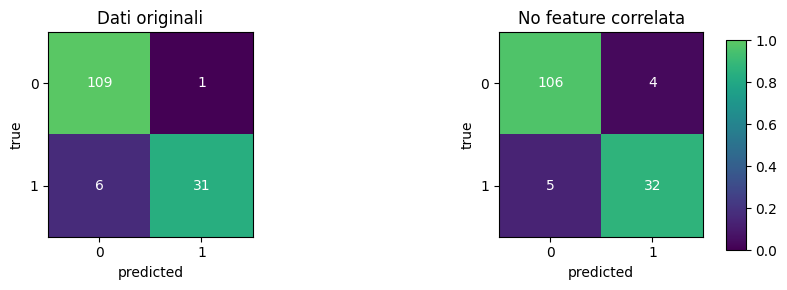

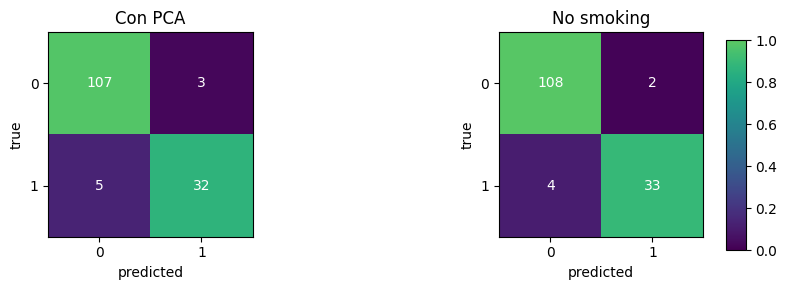

In [36]:
heatMapConstr([cmat_mlp,cmat_mlp_noFeat], ['Dati originali', 'No feature correlata'])
heatMapConstr([cmat_mlp_PCA,cmat_mlp_noSmok], ['Con PCA', 'No smoking'])



## Old (no CV)

In [37]:
"""
cols={'train_f1':[],'validation_f1':[],'time':[]}
for k in GRID.keys():
    cols[k]=[]
MLPresults=pd.DataFrame(cols)

for g in ParameterGrid(GRID):
    print(g)
    mlp1 = MLPClassifier(early_stopping=True, validation_fraction=val_p, random_state=random_seed)
    start=time.time()
    mlp1.set_params(**g)
    mlp1.fit(X_train,y_train)
    stop=time.time()
    y_pred = mlp1.predict(X_train)
    f1 = f1_score(y_train, y_pred, average='weighted')
    y_pred = mlp1.predict(X_val)
    f1_val = f1_score(y_val, y_pred, average='weighted')
    print("\tTempo impiegato: ",stop-start)
    print("\tF1 score (train): ",f1)
    print("\tF1 score (validation): ",f1_val)
    rowToAppend=g.copy()
    rowToAppend['train_f1']=f1
    rowToAppend['validation_f1']=f1_val
    rowToAppend['time']=stop-start
    MLPresults=pd.concat([MLPresults,pd.Series(rowToAppend).to_frame().T],axis=0,ignore_index=True)
    
#display(MLPresults)
"""

'\ncols={\'train_f1\':[],\'validation_f1\':[],\'time\':[]}\nfor k in GRID.keys():\n    cols[k]=[]\nMLPresults=pd.DataFrame(cols)\n\nfor g in ParameterGrid(GRID):\n    print(g)\n    mlp1 = MLPClassifier(early_stopping=True, validation_fraction=val_p, random_state=random_seed)\n    start=time.time()\n    mlp1.set_params(**g)\n    mlp1.fit(X_train,y_train)\n    stop=time.time()\n    y_pred = mlp1.predict(X_train)\n    f1 = f1_score(y_train, y_pred, average=\'weighted\')\n    y_pred = mlp1.predict(X_val)\n    f1_val = f1_score(y_val, y_pred, average=\'weighted\')\n    print("\tTempo impiegato: ",stop-start)\n    print("\tF1 score (train): ",f1)\n    print("\tF1 score (validation): ",f1_val)\n    rowToAppend=g.copy()\n    rowToAppend[\'train_f1\']=f1\n    rowToAppend[\'validation_f1\']=f1_val\n    rowToAppend[\'time\']=stop-start\n    MLPresults=pd.concat([MLPresults,pd.Series(rowToAppend).to_frame().T],axis=0,ignore_index=True)\n\n#display(MLPresults)\n'

In [38]:
#MLPresults['layers'] = MLPresults.apply(lambda x: len(x['hidden_layer_sizes']), axis=1)
#MLPresults['layerSize'] = MLPresults.apply(lambda x: x['hidden_layer_sizes'][0], axis=1)

## SVM

In [39]:
n_features = N-1

print('Valore di default di gamma:', 1 / (n_features * X_trainval.values.var()))
print('Valore auto di gamma:', 1 / n_features)
print('Valore di default di gamma in seguito a PCA:', 1 / (m * X_trainval_pca.var()))
print('Valore auto di gamma in seguito a PCA:', 1 / m)


NameError: name 'N' is not defined

In [ ]:
# Definizione delle liste di valori tra i quali "scorrere" per gli iper-parametri:
C_list = [1, 5, 10, 25, 50, 100]
gamma_list = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000005, 'scale', 'auto']
ker_list = ['rbf', 'sigmoid', 'poly', 'linear']

hparameters = {'kernel':ker_list, 'C':C_list, 'gamma':gamma_list}

In [ ]:
#Dichiarazione della svm
svm = SVC(max_iter = 10000000)

#Dichiarazione delle GridSearch
svm_gs = GridSearchCV(estimator=svm,
                      param_grid=hparameters,
                      scoring='f1_weighted',
                      return_train_score=True,
                      verbose=1)
    
#"Addestramento" delle GridSearch
svm_gs.fit(X_trainval, y_trainval)

# Mostriamo i risultati della Gridsearch con una tabella:
results = pd.DataFrame(svm_gs.cv_results_)

NameError: name 'SVC' is not defined

In [ ]:
# Creazione di una sottomappa di viridis, in modo da avere il verde come massimo
viridis = matplotlib.colormaps['viridis'].resampled(280)
newcolors = viridis(np.linspace(0, 1, 280))[:210]
newcmp=matplotlib.colors.ListedColormap(newcolors)

C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\138624714.py:6: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatMapMatrix = heatMapData.pivot(columns='param_gamma', index='param_C', values=scoreInterest)
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\138624714.py:6: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatMapMatrix = heatMapData.pivot(columns='param_gamma', index='param_C', values=scoreInterest)
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\138624714.py:6: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  heatMapMatrix = heatMapData.pivot(columns='param_gamma', index='param_C', values=scoreInterest)
C:\Users\Anna\AppData\Local\Temp\ipykernel_12388\138624714.py

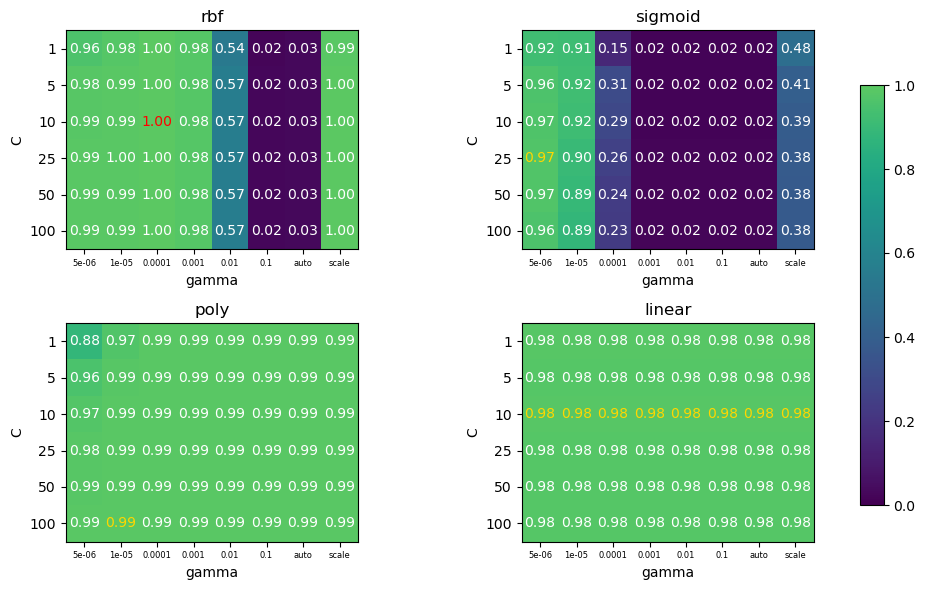

MIGLIORI IPERPARAMETRI


,param_kernel,param_C,param_gamma,mean_test_score
76,rbf,10,0.0001,0.99733


In [ ]:
scoreInterest= 'mean_test_score' #mean_test_score, mean_train_score
interestingColumns = results[['param_kernel','param_C','param_gamma',scoreInterest]]
fig,axs=plt.subplots(2,2,figsize=(12,6))
for i,ker in enumerate(ker_list):
    heatMapData = interestingColumns[interestingColumns['param_kernel']==ker]
    heatMapMatrix = heatMapData.pivot(columns='param_gamma', index='param_C', values=scoreInterest)
    ax=axs[int(i/2),i%2]
    im=ax.imshow(heatMapMatrix,vmin=0,vmax=1,cmap=newcmp)
    ax.set_yticks(range(len(heatMapMatrix.index)))
    ax.set_yticklabels(heatMapMatrix.index)
    ax.set_xticks(range(len(heatMapMatrix.columns)))
    ax.set_xticklabels(heatMapMatrix.columns)
    ax.title.set_text(ker)
    ax.set_xlabel("gamma")
    ax.set_ylabel("C")
    for a in range(len(heatMapMatrix.index)):
        for j in range(len(heatMapMatrix.columns)):
            c="w"
            if heatMapMatrix.iloc[a, j]==interestingColumns[scoreInterest].max():
                c="red"
            elif heatMapMatrix.iloc[a, j]==heatMapMatrix.values.max():
                c="gold"
            text = ax.text(j, a, "{0:.2f}".format(heatMapMatrix.iloc[a, j]),
                        ha="center", va="center", color=c)
fig.tight_layout()
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
#plt.savefig('gs_SVM_'+scoreInterest,dpi=300)
plt.show()
print('MIGLIORI IPERPARAMETRI')
max_elem_row=interestingColumns[scoreInterest].idxmax()
display(pd.DataFrame(interestingColumns.iloc[max_elem_row]).transpose())